### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
t=-1

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import xgboost as xgb
import catboost as cb

In [4]:
#---------- configs
pd.set_option('max_rows',100)
pd.set_option('max_columns',40)

### loading data

In [8]:
train_path = r"datasets/train.csv"
test_path = r"datasets/test.csv"

In [9]:
df = pd.read_csv(train_path,index_col=0,parse_dates=['Date'],dayfirst=True)
df_test = pd.read_csv(test_path,parse_dates=['Date'],dayfirst=True)

df = df.rename(columns={'Temperature(�C)':'Temperature(C)','Dew point temperature(�C)'  : 'Dew point temperature(C)'})
df_test = df_test.rename(columns={'Temperature(�C)':'Temperature(C)','Dew point temperature(�C)'  : 'Dew point temperature(C)'})

## Feature Engineering

##### based on the previous notebook (eda) we will consider the following 

- A) The Hourly cycle has a good correlation. [7am-18pm has the bigger share]
- B) The Temperature has good corr. [high is good except > ~ 27]
- C) The Functional Day has good corr. [functional is good for target]
- D) The Seasons has good corr. [hot season is better]

-------------

- E) The Visibility may prove to be good. [if encoded to very_low visibility vs normal visibiliy].
- F) The RainFall/SnowFall may prove to be good. [if encoded to Snowing / Raining or not].
- G) The Humidity may have something to investigate. [if encoded as 0-80 % normal rentals, 80-100% show sharp decay in rentals]

---------------
- H) the Dew point temperature is strongly corr to Temperature will drop it.
- I) the Solar Radiation may be discarded .. i didn't see good relation.
- J) the holidays didn't prove decisive saying on our target. maybe discarded too.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      5760 non-null   datetime64[ns]
 1   y                         5760 non-null   int64         
 2   Hour                      5760 non-null   int64         
 3   Temperature(C)            5760 non-null   float64       
 4   Humidity(%)               5760 non-null   int64         
 5   Wind speed (m/s)          5760 non-null   float64       
 6   Visibility (10m)          5760 non-null   int64         
 7   Dew point temperature(C)  5760 non-null   float64       
 8   Solar Radiation (MJ/m2)   5760 non-null   float64       
 9   Rainfall(mm)              5760 non-null   float64       
 10  Snowfall (cm)             5760 non-null   float64       
 11  Seasons                   5760 non-null   object        
 12  Holiday             

In [11]:
df.describe()

y         Hour  Temperature(C)  Humidity(%)  \
count  5760.000000  5760.000000     5760.000000  5760.000000   
mean    703.483854    11.500000       12.803559    58.361806   
std     655.249491     6.922788       11.902206    19.840167   
min       0.000000     0.000000      -15.100000     0.000000   
25%     188.000000     5.750000        3.200000    43.000000   
50%     485.500000    11.500000       13.700000    57.000000   
75%    1066.000000    17.250000       22.225000    73.000000   
max    3556.000000    23.000000       39.400000    98.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(C)  \
count       5760.000000       5760.000000               5760.000000   
mean           1.723333       1473.711458                  4.058264   
std            1.047898        585.879880                 13.003582   
min            0.000000         27.000000                -26.900000   
25%            0.900000       1025.750000                 -5.400000   
50%            1.500000       1732.000000                  5.200000   
75%            2.300000       2000.000000                 14.700000   
max            7.400000       2000.000000                 27.200000   

       Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  
count              5760.000000   5760.000000    5760.000000  
mean                  0.572325      0.135122       0.046302  
std                   0.869943      1.075320       0.323728  
min                   0.000000      0.000000       0.000000  
25%                   0.000000      0.000000       0.000000  
50%                   0.010000      0.000000       0.000000  
75%                   0.940000      0.000000       0.000000  
max                   3.520000     35.000000       5.100000

In [12]:
len(df[(df['Snowfall (cm)'])>=1.5])

84

In [13]:
df['Seasons'].value_counts()

Winter    1440
Summer    1440
Spring    1440
Autumn    1440
Name: Seasons, dtype: int64

In [14]:
df_prep = df.copy()

In [15]:
df_prep['Year'] = df['Date'].dt.year.astype('int')
df_prep['Week'] = df['Date'].dt.isocalendar().week.astype('int')
df_prep['Month'] = df['Date'].dt.month.astype('int')
df_prep['WeekDay'] = df['Date'].dt.weekday.astype('int')

In [16]:
def restore_data_series(dataframe,dforiginal,col_name):
    dataframe[col_name] = dforiginal[col_name]

In [17]:
def map_data_series(dataframe,col_name,from_vals,to_vals):
    dataframe[col_name].replace(from_vals,to_vals,inplace=True)

In [18]:
def new_feature_data_series(dataframe,col_name,function,new_col_name):
       dataframe[new_col_name]  = dataframe[col_name].apply(function,axis=1)

In [19]:
map_data_series(df_prep,'Functioning Day',['Yes','No'],[1,0])

In [20]:
map_data_series(df_prep,'Holiday',['Holiday','No Holiday'],[1,0])

In [21]:
map_data_series(df_prep,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [22]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def rush_hour(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] in [6,7,8,9,10,16,17,18,19,20]):
        return 1
    else:
        return 0
    
def rush_hour_grad_2(df):
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day']

    return (np.exp(-abs(df['Hour'] - 8)) +  np.exp(-abs(df['Hour'] - 18))) * is_functional

def rush_hour_grad(df):
    #from 8 am , 6 pm
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 8) <= rush_range_1): 
        return np.exp(-abs(df['Hour'] - 8)) * is_functional
    
    elif (abs(df['Hour'] - 18) <= rush_range_2):
        return np.exp(-abs(df['Hour'] - 18)) * is_functional
    else:
        return 0
    
def dead_hour_grad(df):
    dead_range_1 = 3 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 4) <= dead_range_1): 
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0
    
def dead_hour_grad_2(df):
    #dead_range_1 = 5 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if(df['Hour'] in [22,23,0,1,2,3,4,5]):
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0   
new_feature_data_series(df_prep,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')
new_feature_data_series(df_prep,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')

In [23]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def day_night(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] >=6 and df['Hour'] <=18):
        return 1
    else:
        return 0

new_feature_data_series(df_prep,['Hour'],day_night,'day_night')

In [24]:
new_feature_data_series(df_prep,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')

In [25]:
new_feature_data_series(df_prep,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [26]:
new_feature_data_series(df_prep,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)','Wind speed (m/s)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [27]:
#something is wrong in feels like equation
# def feels_like(df):
#     ### inputs temp & humidity , outputs feels like temp
#     ## equation heat_index = c1 + c2 T + c3 R + c4 TR + c5 T^2 + c6 R^2 +...
#     c1 = -8.78469475556
#     c2 = 1.61139411
#     c3 = 2.33854883889
#     c4 = -0.14611605
#     c5 = -0.012308094
#     c6 = -0.0164248277778
#     c7 = 0.002211732
#     c8 = 0.00072546
#     c9 = -0.000003582
#     T = df['Temperature(C)']
#     R = df['Humidity(%)']
#     is_functionalDay = df['Functioning Day']
#     HI = (c1) + (c2 * T) +( c3 * R) + (c4  * T * R )+ (c5 *( T**2 ))+ (c6 * (R**2)) + (c7 * (T**2) * R) + (c8 * T * (R**2)) + (c9 * (T**2) * (R**2))
#     #HI = c1 + (c2 * T) +( c3 * R )+ (c4  * T * R )+ (c5 * T**2 )
#     return HI 

#new_feature_data_series(df_prep,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
def humidex(df):
    ### humidex
    ## eq H = Tair + 5/9 * [(6.11 * e^5417.7530 * (a-b)) - 10 ]
    Tair = df['Temperature(C)']
    Tdew = df['Dew point temperature(C)']
    is_functionalDay = df['Functioning Day']
    a = 1/273.16
    b = 1/(273.15 + Tdew)
    Humidex = Tair + (5/9) * (6.11 * np.exp(5417.7530 * (a-b)) -10)
    return Humidex  
new_feature_data_series(df_prep,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [28]:
df_prep['Ideal'] = df[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [29]:
df_prep["Ideal"].value_counts()

1    4548
0    1212
Name: Ideal, dtype: int64

In [30]:
def visibility(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <=250 :
        return 0
    elif df['Visibility (10m)'] <=350 :
        return 1
    elif df['Visibility (10m)'] <=450 :
        return 1
    elif df['Visibility (10m)'] <=550 :
        return 2
    elif df['Visibility (10m)'] <=650 :
        return 2
    elif df['Visibility (10m)'] <=850 :
        return 3
    elif df['Visibility (10m)'] <=1150 :
        return 3
    elif df['Visibility (10m)'] <=1350 :
        return 4
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility,'Visibility_cat')

In [31]:
def visibility_dist(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <100 :     #can't see
        return 1
    elif df['Visibility (10m)'] <400 :   # foggy
        return 2
    elif df['Visibility (10m)'] <1000 :  # low fog
        return 3
    elif df['Visibility (10m)'] <2000 :  # no fog (good vision)
        return 4
    elif df['Visibility (10m)'] <4000 :  # no fog (excellent vision)
        return 5
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [32]:
# for rainfall

def rain_fall(df):
    # 0:2.5 , 
    
    if df['Rainfall(mm)'] < 0.5 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [33]:
def snow_fall(df):
    # 0:2.5 , 
    
    if df['Snowfall (cm)'] == 0 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [34]:
def Sunny_Hot (df):
    if ((df['Temperature(C)']>25)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_hot (df):
    if ((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_hot(df):  
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_hot(df): 
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_hot(df):  
    if((df['Temperature(C)']>25)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_hot(df): 
    if((df['Temperature(C)']>25)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [35]:
def Sunny_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [36]:
def Sunny_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False
def Night_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [37]:
def Sunny_Freezing (df):
    if ((df['Temperature(C)']<=0)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Freezing (df):
    if ((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Freezing(df):  
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Freezing(df): 
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False

def Night_Freezing(df): 
    if((df['Temperature(C)']<=0)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Snow(df):
    if (df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] >0):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [38]:
df_prep['Weather_State'] =df_prep[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [39]:
Weather_Description_list = ['Night_Freezing', 'Cloudy_Freezing', 'PCloudy_Freezing',
                            'Clear_Cold', 'PCloudy_Cold', 'Cloudy_Cold', 'Night_Cold',
                            'Rain_Cold', 'Clear_Freezing', 'Rain&Snow', 'Snow_Freezing',
                            'Snow_Cold', 'Sunny_Freezing', 'Sunny_Cold', 'Sunny_Warm',
                            'Clear_Warm', 'PCloudy_Warm', 'Cloudy_Warm', 'Night_Warm',
                            'Rain_Warm', 'Sunny_hot', 'Clear_hot', 'Cloudy_hot', 'Night_hot',
                            'PCloudy_hot', 'Rain_hot']
length = len(Weather_Description_list)+1
Weather_Description_neumeric = [*range(1, length, 1)]

In [40]:
map_data_series(df_prep,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [41]:
new_feature_data_series(df_prep,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [42]:
new_feature_data_series(df_prep,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [43]:
def Clear(df):
    if (df['Solar Radiation (MJ/m2)'] >2) & (df['day_night'] ==1):
        return 1
    else:
        return 0
    
def Few_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Scatterd_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1.5)&(df['Solar Radiation (MJ/m2)'] >1)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Partly_Cloudy(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Cloudy(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.5) & (df['day_night'] ==1)):
        return 1
    else:
        return 0
    
def Night(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.8) & (df['day_night'] ==0)):
        return 1
    else:
        return 0
    

In [44]:
def Mist(df):
    if df['Visibility_dist'] == 3:
        return 1
    else:
        return 0
    
def Fog(df):
    if ((df['Visibility_dist'] == 1) | (df['Visibility_dist'] == 2)) :
        return 1
    else:
        return 0

In [45]:
def Light_Rain(df):
    if ((df['Rainfall(mm)']) >0 & (df['Rainfall(mm)'] < 2.5))  :
        return 1
    else:
        return 0
    
def Heavy_Rain(df):
    if (df['Rainfall(mm)'] >= 2.5)  :
        return 1
    else:
        return 0
def Ice_pallets(df):
        if ((df['Rainfall(mm)'] > 0 )& (df['Snowfall (cm)'] > 0 ))  :
            return 1
        else:
            return 0


In [46]:
def Light_Snow(df):
    if ((df['Snowfall (cm)']) >0 & (df['Snowfall (cm)'] < 1))  :
        return 1
    else:
        return 0
    
def Snow(df):
    if (df['Snowfall (cm)'] >= 1)  :
        return 1
    else:
        return 0

In [47]:
def Cond1(df):
    if Clear(df) or Few_Clouds(df) or Partly_Cloudy(df) or Cloudy(df):
        return 1
    else:
        return 0
def Cond2(df):
    if (Mist(df) and Cloudy(df)) or (Mist(df) and Partly_Cloudy(df)) or (Mist(df) and Few_Clouds(df)) or Mist(df):
        return 1
    else:
        return 0
def Cond3(df):
    if Light_Snow(df) or (Light_Rain(df) and Scatterd_Clouds(df)) or Light_Rain(df):
        return 1
    else:
        return 0
def Cond4(df):
    if (Ice_pallets(df) and Mist(df)) or (Snow(df) and Fog(df)) or Snow(df) :
        return 1
    else:
        return 0
def Cond5(df):
    if Night(df):
        return 1
    else:
        return 0

In [48]:
df_prep['Sky_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 
                 else 5, axis = 1)

In [49]:
def Hot(df):
    if (df['Temperature(C)']>25):
        return 1
    else:
        return 0
def Warm(df):
    if ((df['Temperature(C)']<=25)&(df['Temperature(C)']>10)):
        return 1
    else:
        return 0
def Cold(df):
    if ((df['Temperature(C)']<=10)&(df['Temperature(C)']>0)):
        return 1
    else:
        return 0
def Freezing(df):
    if (df['Temperature(C)']<=0):
        return 1
    else:
        return 0

In [50]:
df_prep['Temp_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [51]:
df_prep[["Temp_State"]].value_counts()

Temp_State
1             2396
2             1358
3             1004
4             1002
dtype: int64

In [52]:
new_feature_data_series(df_prep,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [53]:
df_prep["Date_tmp"] = df_prep['Date'].dt.to_period('M')
new_feature_df = pd.DataFrame(df_prep.groupby(['Date_tmp', 'Year'])['y'].mean()).sort_values(["Year"])
new_feature_df = pd.DataFrame(new_feature_df['y'].shift(+t))
new_feature_df.reset_index(inplace=True)
new_feature_df.rename(columns={'y':'Prev Month y'}, inplace=True)
new_feature_df.drop(['Year'], axis = 1, inplace =True)
new_feature_df.fillna(new_feature_df.mean(), inplace = True)

In [54]:
df_prep = pd.merge(df_prep, new_feature_df, on='Date_tmp', how='left')

In [55]:
df_prep["Temperature lag1"] = df_prep["Temperature(C)"].shift(+t)
df_prep["Temperature lag1"].fillna(0, inplace=True)

df_prep["Rainfall lag1"] = df_prep["Rainfall(mm)"].shift(+t)
df_prep["Rainfall lag1"].fillna(0, inplace=True)

df_prep["Visibility  lag1"] = df_prep["Visibility (10m)"].shift(+t)
df_prep["Visibility  lag1"].fillna(0, inplace=True)

df_prep["Wind speed lag1"] = df_prep["Wind speed (m/s)"].shift(+t)
df_prep["Wind speed lag1"].fillna(0, inplace=True)

df_prep["Weather_State lag1"] = df_prep["Weather_State"].shift(+t)
df_prep["Weather_State lag1"].fillna(0, inplace=True)

df_prep["Humidity lag1"] = df_prep["Humidity(%)"].shift(+t)
df_prep["Humidity lag1"].fillna(0, inplace=True)

df_prep["Rush_hour lag1"] = df_prep["Rush_hour"].shift(+t)
df_prep["Rush_hour lag1"].fillna(0, inplace=True)

df_prep["Dead_hour lag1"] = df_prep["Dead_hour"].shift(+t)
df_prep["Dead_hour lag1"].fillna(0, inplace=True)

df_prep["Ideal lag1"] = df_prep["Ideal"].shift(+t)
df_prep["Ideal lag1"].fillna(0, inplace=True)

df_prep["Dew point temperature(C) lag1"] = df_prep["Dew point temperature(C)"].shift(+t)
df_prep["Dew point temperature(C) lag1"].fillna(0, inplace=True)

In [56]:
df_prep.columns.size

48

----
# Training The Model

####  Our Scoring Metric (RMSLE)

In [208]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1.0) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1.0) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

def NumPyRMSLE(y_true:list, y_pred:list) -> float:
    """
        The Root Mean Squared Log Error (RMSLE) metric using only NumPy
        N.B. This function is a lot slower than sklearn's implementation
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    n = len(y_true)
    msle = np.mean([(np.log(y_pred[i] + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 

##### Selecting features and splitting (do this everytime you change the features! and want to do training)

In [209]:

selected_features = ['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)',"Dew point temperature(C)",
                     'Snowfall (cm)','Wind speed (m/s)','Visibility (10m)','WeekDay',
                     'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
                     'Functioning Day','Rush_hour','Dead_hour','Weather_State',
                     'Weather&visb','Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast',
                     'Temperature lag1','Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
                     'Weather_State lag1', 'Humidity lag1', 'Rush_hour lag1',
                     'Dead_hour lag1', 'Ideal lag1',"Dew point temperature(C) lag1"]
  

train = df_prep.copy()
train["y"] = np.log(df_prep["y"]+0.00001) ##--- someone explain why this works better than +1
#train["y"] = df_prep["y"]
X1 = train[selected_features]
y1 = train["y"]

# tss = TimeSeriesSplit(n_splits=2)
# train_ind,test_ind  = tss.split(X1,groups=[20,1])

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state=42,shuffle=True,)

In [210]:
len(selected_features)

34

---
## XGB

In [56]:
prev_trainX = 0
prev_testX = 0

In [215]:
XGB = xgb.XGBRegressor(n_estimators=2100,subsample=0.887
                       ,colsample_bytree = 0.9,colsample_bylevel=0.9,
                       learning_rate=0.056,n_jobs=8,max_depth =3)

XGB.fit(X_train, y_train)

y_pred_trainXGB = XGB.predict(X_train)   
y_pred_testXGB = XGB.predict(X_test)

rmsle_trainXGB =  rmsle(y_train, y_pred_trainXGB, True)
rmsle_testXGB  = rmsle(y_test, y_pred_testXGB, True)

print('(Train) RF RMSLE:',rmsle_trainXGB )
print('(Test) RF RMSLE:',rmsle_testXGB  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainX)
print('(Test) Prev RMSLE:', prev_testX)
prev_trainX = rmsle_trainXGB 
prev_testX = rmsle_testXGB 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainXGB) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testXGB) * 100,' %')


[12:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(Train) RF RMSLE: 0.11250070027806189
(Test) RF RMSLE: 0.24486897512559921
---------------------------------
(Train) Prev RMSLE: 0.11421883099670818
(Test) Prev RMSLE: 0.24616225663575783
---------------------------------
Training Score: 99.90283451387376  %
Test Score: 99.60535325742816  %


<Figure size 864x576 with 0 Axes>

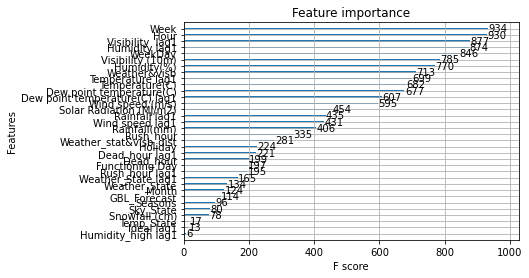

In [109]:
figure(figsize=(12, 8))
xgb.plot_importance(XGB)
plt.show()

In [110]:
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)
cv_score = cross_val_score(XGB, X_train, y_train, n_jobs=4, verbose = 1, cv=kfold, scoring=rmsle_scorer)
print(f'cv_error : {-cv_score.mean()}')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


cv_error : 0.27929980421249934


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.1s finished


---
## GBRegressor

In [60]:
prev_trainGBR = 0
prev_testGBR = 0

In [221]:
#GBR learn_rate = 0.05 , n_est = 1000 

GBR = GradientBoostingRegressor(random_state=0,loss='ls',
    n_estimators=1500,subsample=0.7,learning_rate=0.034,
    criterion='friedman_mse')

GBR.fit(X_train, y_train)

y_pred_trainGBR = GBR.predict(X_train)  
y_pred_testGBR = GBR.predict(X_test)  


rmsle_trainGBR =  rmsle(y_train, y_pred_trainGBR, True)
rmsle_testGBR  = rmsle(y_test, y_pred_testGBR, True)

print('(Train)  GBR  RMSLE:',rmsle_trainGBR )
print('(Test) GBR RMSLE:',rmsle_testGBR  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainGBR)
print('(Test) Prev RMSLE:', prev_testGBR)
prev_trainGBR = rmsle_trainGBR
prev_testGBR = rmsle_testGBR 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainGBR) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testGBR) * 100,' %')

(Train)  GBR  RMSLE: 0.16567765234031198
(Test) GBR RMSLE: 0.25753499999248364
---------------------------------
(Train) Prev RMSLE: 0.15607245439817738
(Test) Prev RMSLE: 0.2585977300833734
---------------------------------
Training Score: 99.78872615304876  %
Test Score: 99.56632492292673  %


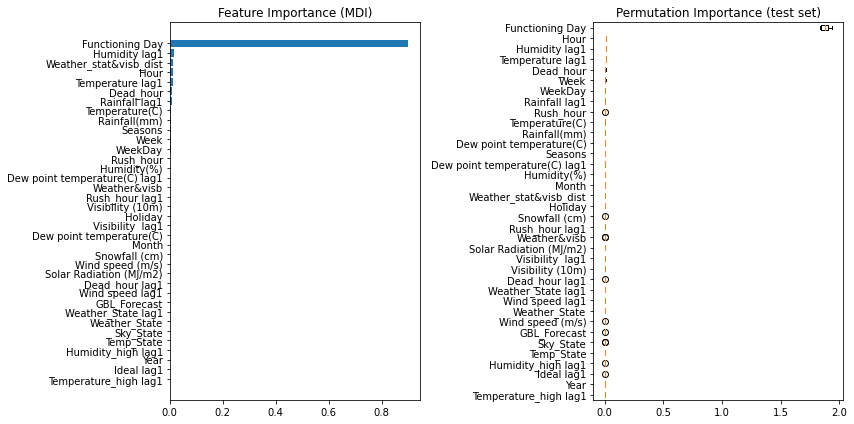

In [117]:
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
feature_names = list(X_train.columns.values)
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(GBR, X_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

---
## CatBoost 

In [224]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
#grid = {'depth': [4], 'iterations': [2500], 'l2_leaf_reg': [1], 'learning_rate': [0.05]} #0.42222

model = cb.CatBoostRegressor(loss_function='RMSE',random_state=0)
grid = {'depth': [4],'iterations': [2500], 'l2_leaf_reg': [1], 'learning_rate': [0.038]} ##0.4229364603151052

model.grid_search(grid, train_dataset)
pred_test = model.predict(X_test)
pred_train=model.predict(X_train)
# rmse= (np.sqrt(mean_squared_error(y_test, pred_test)))
# r2 = r2_score(y_test, pred_test)
print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))

0:	learn: 6.2848570	test: 6.2069932	best: 6.2069932 (0)	total: 2.13ms	remaining: 5.33s
1:	learn: 6.0536459	test: 5.9769984	best: 5.9769984 (1)	total: 4.1ms	remaining: 5.12s
2:	learn: 5.8318241	test: 5.7574840	best: 5.7574840 (2)	total: 5.81ms	remaining: 4.83s
3:	learn: 5.6171036	test: 5.5438884	best: 5.5438884 (3)	total: 7.69ms	remaining: 4.8s
4:	learn: 5.4087240	test: 5.3374019	best: 5.3374019 (4)	total: 9.42ms	remaining: 4.7s
5:	learn: 5.2108148	test: 5.1407162	best: 5.1407162 (5)	total: 11.1ms	remaining: 4.62s
6:	learn: 5.0195868	test: 4.9505004	best: 4.9505004 (6)	total: 13ms	remaining: 4.63s
7:	learn: 4.8347584	test: 4.7683085	best: 4.7683085 (7)	total: 14.8ms	remaining: 4.6s
8:	learn: 4.6569083	test: 4.5916420	best: 4.5916420 (8)	total: 16.5ms	remaining: 4.57s
9:	learn: 4.4880421	test: 4.4245263	best: 4.4245263 (9)	total: 18.3ms	remaining: 4.55s
10:	learn: 4.3267354	test: 4.2648064	best: 4.2648064 (10)	total: 19.9ms	remaining: 4.5s
11:	learn: 4.1720764	test: 4.1109900	best: 4.110

178:	learn: 0.3970060	test: 0.4041946	best: 0.4041946 (178)	total: 330ms	remaining: 4.28s
179:	learn: 0.3960220	test: 0.4034147	best: 0.4034147 (179)	total: 332ms	remaining: 4.28s
180:	learn: 0.3954356	test: 0.4031358	best: 0.4031358 (180)	total: 334ms	remaining: 4.28s
181:	learn: 0.3948740	test: 0.4025527	best: 0.4025527 (181)	total: 350ms	remaining: 4.46s
182:	learn: 0.3941247	test: 0.4016844	best: 0.4016844 (182)	total: 352ms	remaining: 4.46s
183:	learn: 0.3934671	test: 0.4013860	best: 0.4013860 (183)	total: 354ms	remaining: 4.45s
184:	learn: 0.3928028	test: 0.4008342	best: 0.4008342 (184)	total: 355ms	remaining: 4.45s
185:	learn: 0.3922400	test: 0.4003187	best: 0.4003187 (185)	total: 357ms	remaining: 4.44s
186:	learn: 0.3913515	test: 0.3996302	best: 0.3996302 (186)	total: 359ms	remaining: 4.43s
187:	learn: 0.3908154	test: 0.3990072	best: 0.3990072 (187)	total: 360ms	remaining: 4.43s
188:	learn: 0.3901305	test: 0.3983431	best: 0.3983431 (188)	total: 362ms	remaining: 4.42s
189:	learn

349:	learn: 0.3119436	test: 0.3285498	best: 0.3285498 (349)	total: 664ms	remaining: 4.08s
350:	learn: 0.3114816	test: 0.3281446	best: 0.3281446 (350)	total: 666ms	remaining: 4.08s
351:	learn: 0.3111419	test: 0.3278604	best: 0.3278604 (351)	total: 668ms	remaining: 4.07s
352:	learn: 0.3108954	test: 0.3276405	best: 0.3276405 (352)	total: 669ms	remaining: 4.07s
353:	learn: 0.3106463	test: 0.3273861	best: 0.3273861 (353)	total: 671ms	remaining: 4.07s
354:	learn: 0.3102390	test: 0.3270785	best: 0.3270785 (354)	total: 673ms	remaining: 4.07s
355:	learn: 0.3098067	test: 0.3267044	best: 0.3267044 (355)	total: 675ms	remaining: 4.06s
356:	learn: 0.3095651	test: 0.3264936	best: 0.3264936 (356)	total: 676ms	remaining: 4.06s
357:	learn: 0.3093198	test: 0.3264457	best: 0.3264457 (357)	total: 678ms	remaining: 4.06s
358:	learn: 0.3089704	test: 0.3263410	best: 0.3263410 (358)	total: 680ms	remaining: 4.05s
359:	learn: 0.3084511	test: 0.3262943	best: 0.3262943 (359)	total: 682ms	remaining: 4.06s
360:	learn

506:	learn: 0.2699682	test: 0.3035223	best: 0.3035223 (506)	total: 990ms	remaining: 3.89s
507:	learn: 0.2697523	test: 0.3033220	best: 0.3033220 (507)	total: 996ms	remaining: 3.9s
508:	learn: 0.2696057	test: 0.3032460	best: 0.3032460 (508)	total: 998ms	remaining: 3.9s
509:	learn: 0.2694088	test: 0.3031518	best: 0.3031518 (509)	total: 1s	remaining: 3.9s
510:	learn: 0.2691971	test: 0.3030697	best: 0.3030697 (510)	total: 1s	remaining: 3.9s
511:	learn: 0.2689243	test: 0.3028759	best: 0.3028759 (511)	total: 1s	remaining: 3.9s
512:	learn: 0.2687920	test: 0.3027802	best: 0.3027802 (512)	total: 1.01s	remaining: 3.9s
513:	learn: 0.2686062	test: 0.3027217	best: 0.3027217 (513)	total: 1.01s	remaining: 3.9s
514:	learn: 0.2684705	test: 0.3026534	best: 0.3026534 (514)	total: 1.01s	remaining: 3.89s
515:	learn: 0.2683360	test: 0.3026454	best: 0.3026454 (515)	total: 1.01s	remaining: 3.89s
516:	learn: 0.2680745	test: 0.3028363	best: 0.3026454 (515)	total: 1.02s	remaining: 3.9s
517:	learn: 0.2679222	test:

651:	learn: 0.2433249	test: 0.2918704	best: 0.2918704 (651)	total: 1.32s	remaining: 3.75s
652:	learn: 0.2430113	test: 0.2916707	best: 0.2916707 (652)	total: 1.32s	remaining: 3.75s
653:	learn: 0.2428220	test: 0.2914407	best: 0.2914407 (653)	total: 1.33s	remaining: 3.74s
654:	learn: 0.2425972	test: 0.2913103	best: 0.2913103 (654)	total: 1.33s	remaining: 3.74s
655:	learn: 0.2424561	test: 0.2911348	best: 0.2911348 (655)	total: 1.33s	remaining: 3.74s
656:	learn: 0.2423545	test: 0.2910425	best: 0.2910425 (656)	total: 1.33s	remaining: 3.74s
657:	learn: 0.2422696	test: 0.2910319	best: 0.2910319 (657)	total: 1.33s	remaining: 3.73s
658:	learn: 0.2422143	test: 0.2910005	best: 0.2910005 (658)	total: 1.34s	remaining: 3.73s
659:	learn: 0.2421295	test: 0.2909474	best: 0.2909474 (659)	total: 1.34s	remaining: 3.73s
660:	learn: 0.2420222	test: 0.2909980	best: 0.2909474 (659)	total: 1.34s	remaining: 3.73s
661:	learn: 0.2418790	test: 0.2910577	best: 0.2909474 (659)	total: 1.34s	remaining: 3.72s
662:	learn

746:	learn: 0.2287916	test: 0.2872880	best: 0.2872880 (746)	total: 1.49s	remaining: 3.49s
747:	learn: 0.2285739	test: 0.2876322	best: 0.2872880 (746)	total: 1.49s	remaining: 3.49s
748:	learn: 0.2284770	test: 0.2876054	best: 0.2872880 (746)	total: 1.49s	remaining: 3.49s
749:	learn: 0.2284001	test: 0.2875561	best: 0.2872880 (746)	total: 1.49s	remaining: 3.49s
750:	learn: 0.2282165	test: 0.2874565	best: 0.2872880 (746)	total: 1.5s	remaining: 3.49s
751:	learn: 0.2280911	test: 0.2873656	best: 0.2872880 (746)	total: 1.5s	remaining: 3.48s
752:	learn: 0.2280070	test: 0.2873387	best: 0.2872880 (746)	total: 1.5s	remaining: 3.48s
753:	learn: 0.2278424	test: 0.2872413	best: 0.2872413 (753)	total: 1.5s	remaining: 3.48s
754:	learn: 0.2277403	test: 0.2872186	best: 0.2872186 (754)	total: 1.5s	remaining: 3.48s
755:	learn: 0.2276081	test: 0.2872036	best: 0.2872036 (755)	total: 1.51s	remaining: 3.48s
756:	learn: 0.2273678	test: 0.2871340	best: 0.2871340 (756)	total: 1.51s	remaining: 3.47s
757:	learn: 0.2

843:	learn: 0.2159653	test: 0.2842849	best: 0.2841764 (842)	total: 1.66s	remaining: 3.25s
844:	learn: 0.2158768	test: 0.2842424	best: 0.2841764 (842)	total: 1.66s	remaining: 3.25s
845:	learn: 0.2157961	test: 0.2842214	best: 0.2841764 (842)	total: 1.66s	remaining: 3.25s
846:	learn: 0.2156271	test: 0.2841057	best: 0.2841057 (846)	total: 1.66s	remaining: 3.25s
847:	learn: 0.2155376	test: 0.2841280	best: 0.2841057 (846)	total: 1.67s	remaining: 3.25s
848:	learn: 0.2153797	test: 0.2841170	best: 0.2841057 (846)	total: 1.67s	remaining: 3.24s
849:	learn: 0.2151232	test: 0.2837603	best: 0.2837603 (849)	total: 1.67s	remaining: 3.24s
850:	learn: 0.2149640	test: 0.2835945	best: 0.2835945 (850)	total: 1.67s	remaining: 3.24s
851:	learn: 0.2148243	test: 0.2835061	best: 0.2835061 (851)	total: 1.67s	remaining: 3.24s
852:	learn: 0.2147503	test: 0.2835313	best: 0.2835061 (851)	total: 1.68s	remaining: 3.24s
853:	learn: 0.2146280	test: 0.2835415	best: 0.2835061 (851)	total: 1.68s	remaining: 3.23s
854:	learn

1011:	learn: 0.1974733	test: 0.2787044	best: 0.2786208 (1010)	total: 1.99s	remaining: 2.92s
1012:	learn: 0.1973372	test: 0.2790347	best: 0.2786208 (1010)	total: 1.99s	remaining: 2.92s
1013:	learn: 0.1971841	test: 0.2789297	best: 0.2786208 (1010)	total: 1.99s	remaining: 2.92s
1014:	learn: 0.1971061	test: 0.2789130	best: 0.2786208 (1010)	total: 1.99s	remaining: 2.92s
1015:	learn: 0.1969273	test: 0.2788221	best: 0.2786208 (1010)	total: 2s	remaining: 2.92s
1016:	learn: 0.1968313	test: 0.2788315	best: 0.2786208 (1010)	total: 2s	remaining: 2.91s
1017:	learn: 0.1966883	test: 0.2789128	best: 0.2786208 (1010)	total: 2s	remaining: 2.91s
1018:	learn: 0.1966047	test: 0.2789180	best: 0.2786208 (1010)	total: 2s	remaining: 2.91s
1019:	learn: 0.1965156	test: 0.2788826	best: 0.2786208 (1010)	total: 2s	remaining: 2.91s
1020:	learn: 0.1964454	test: 0.2788822	best: 0.2786208 (1010)	total: 2.01s	remaining: 2.91s
1021:	learn: 0.1963833	test: 0.2788301	best: 0.2786208 (1010)	total: 2.01s	remaining: 2.9s
1022

1107:	learn: 0.1885751	test: 0.2765139	best: 0.2764921 (1105)	total: 2.16s	remaining: 2.71s
1108:	learn: 0.1885692	test: 0.2765116	best: 0.2764921 (1105)	total: 2.16s	remaining: 2.71s
1109:	learn: 0.1884463	test: 0.2765124	best: 0.2764921 (1105)	total: 2.16s	remaining: 2.7s
1110:	learn: 0.1883788	test: 0.2765201	best: 0.2764921 (1105)	total: 2.16s	remaining: 2.7s
1111:	learn: 0.1882920	test: 0.2764197	best: 0.2764197 (1111)	total: 2.16s	remaining: 2.7s
1112:	learn: 0.1882022	test: 0.2764043	best: 0.2764043 (1112)	total: 2.16s	remaining: 2.7s
1113:	learn: 0.1880974	test: 0.2763571	best: 0.2763571 (1113)	total: 2.17s	remaining: 2.69s
1114:	learn: 0.1879517	test: 0.2761878	best: 0.2761878 (1114)	total: 2.17s	remaining: 2.69s
1115:	learn: 0.1879083	test: 0.2761822	best: 0.2761822 (1115)	total: 2.17s	remaining: 2.69s
1116:	learn: 0.1878417	test: 0.2761188	best: 0.2761188 (1116)	total: 2.17s	remaining: 2.69s
1117:	learn: 0.1876905	test: 0.2760499	best: 0.2760499 (1117)	total: 2.17s	remaining

1274:	learn: 0.1756171	test: 0.2722426	best: 0.2722426 (1274)	total: 2.49s	remaining: 2.39s
1275:	learn: 0.1756109	test: 0.2722351	best: 0.2722351 (1275)	total: 2.49s	remaining: 2.39s
1276:	learn: 0.1755586	test: 0.2722121	best: 0.2722121 (1276)	total: 2.49s	remaining: 2.39s
1277:	learn: 0.1754804	test: 0.2720544	best: 0.2720544 (1277)	total: 2.5s	remaining: 2.38s
1278:	learn: 0.1754053	test: 0.2721132	best: 0.2720544 (1277)	total: 2.5s	remaining: 2.38s
1279:	learn: 0.1753725	test: 0.2720901	best: 0.2720544 (1277)	total: 2.5s	remaining: 2.38s
1280:	learn: 0.1752995	test: 0.2719989	best: 0.2719989 (1280)	total: 2.5s	remaining: 2.38s
1281:	learn: 0.1752549	test: 0.2719909	best: 0.2719909 (1281)	total: 2.5s	remaining: 2.38s
1282:	learn: 0.1752109	test: 0.2719540	best: 0.2719540 (1282)	total: 2.5s	remaining: 2.38s
1283:	learn: 0.1751323	test: 0.2718959	best: 0.2718959 (1283)	total: 2.51s	remaining: 2.37s
1284:	learn: 0.1750886	test: 0.2719091	best: 0.2718959 (1283)	total: 2.51s	remaining: 

1370:	learn: 0.1690407	test: 0.2697513	best: 0.2697513 (1370)	total: 2.65s	remaining: 2.19s
1371:	learn: 0.1689408	test: 0.2696343	best: 0.2696343 (1371)	total: 2.66s	remaining: 2.18s
1372:	learn: 0.1688833	test: 0.2696239	best: 0.2696239 (1372)	total: 2.66s	remaining: 2.18s
1373:	learn: 0.1687911	test: 0.2696220	best: 0.2696220 (1373)	total: 2.66s	remaining: 2.18s
1374:	learn: 0.1687357	test: 0.2695977	best: 0.2695977 (1374)	total: 2.66s	remaining: 2.18s
1375:	learn: 0.1686751	test: 0.2695651	best: 0.2695651 (1375)	total: 2.67s	remaining: 2.18s
1376:	learn: 0.1686023	test: 0.2694796	best: 0.2694796 (1376)	total: 2.67s	remaining: 2.17s
1377:	learn: 0.1684589	test: 0.2694393	best: 0.2694393 (1377)	total: 2.67s	remaining: 2.17s
1378:	learn: 0.1684196	test: 0.2695126	best: 0.2694393 (1377)	total: 2.67s	remaining: 2.17s
1379:	learn: 0.1683807	test: 0.2694848	best: 0.2694393 (1377)	total: 2.67s	remaining: 2.17s
1380:	learn: 0.1682721	test: 0.2694660	best: 0.2694393 (1377)	total: 2.68s	remai

1465:	learn: 0.1631159	test: 0.2688585	best: 0.2687243 (1463)	total: 2.82s	remaining: 1.99s
1466:	learn: 0.1630624	test: 0.2688427	best: 0.2687243 (1463)	total: 2.83s	remaining: 1.99s
1467:	learn: 0.1630271	test: 0.2688221	best: 0.2687243 (1463)	total: 2.83s	remaining: 1.99s
1468:	learn: 0.1629521	test: 0.2688302	best: 0.2687243 (1463)	total: 2.83s	remaining: 1.99s
1469:	learn: 0.1628940	test: 0.2688089	best: 0.2687243 (1463)	total: 2.83s	remaining: 1.98s
1470:	learn: 0.1628709	test: 0.2688288	best: 0.2687243 (1463)	total: 2.83s	remaining: 1.98s
1471:	learn: 0.1627537	test: 0.2688219	best: 0.2687243 (1463)	total: 2.83s	remaining: 1.98s
1472:	learn: 0.1627021	test: 0.2687759	best: 0.2687243 (1463)	total: 2.84s	remaining: 1.98s
1473:	learn: 0.1626783	test: 0.2687759	best: 0.2687243 (1463)	total: 2.84s	remaining: 1.98s
1474:	learn: 0.1626444	test: 0.2687909	best: 0.2687243 (1463)	total: 2.84s	remaining: 1.97s
1475:	learn: 0.1626178	test: 0.2688432	best: 0.2687243 (1463)	total: 2.84s	remai

1637:	learn: 0.1546677	test: 0.2676824	best: 0.2675320 (1620)	total: 3.16s	remaining: 1.66s
1638:	learn: 0.1546095	test: 0.2677023	best: 0.2675320 (1620)	total: 3.16s	remaining: 1.66s
1639:	learn: 0.1545777	test: 0.2676899	best: 0.2675320 (1620)	total: 3.16s	remaining: 1.66s
1640:	learn: 0.1545480	test: 0.2676905	best: 0.2675320 (1620)	total: 3.16s	remaining: 1.66s
1641:	learn: 0.1544525	test: 0.2676271	best: 0.2675320 (1620)	total: 3.17s	remaining: 1.65s
1642:	learn: 0.1543917	test: 0.2676342	best: 0.2675320 (1620)	total: 3.17s	remaining: 1.65s
1643:	learn: 0.1543504	test: 0.2676615	best: 0.2675320 (1620)	total: 3.17s	remaining: 1.65s
1644:	learn: 0.1542913	test: 0.2676412	best: 0.2675320 (1620)	total: 3.17s	remaining: 1.65s
1645:	learn: 0.1542575	test: 0.2676264	best: 0.2675320 (1620)	total: 3.17s	remaining: 1.65s
1646:	learn: 0.1542024	test: 0.2676269	best: 0.2675320 (1620)	total: 3.17s	remaining: 1.64s
1647:	learn: 0.1541336	test: 0.2676433	best: 0.2675320 (1620)	total: 3.18s	remai

1730:	learn: 0.1499608	test: 0.2667948	best: 0.2667725 (1729)	total: 3.32s	remaining: 1.48s
1731:	learn: 0.1499118	test: 0.2667217	best: 0.2667217 (1731)	total: 3.33s	remaining: 1.47s
1732:	learn: 0.1498816	test: 0.2667158	best: 0.2667158 (1732)	total: 3.33s	remaining: 1.47s
1733:	learn: 0.1498370	test: 0.2667271	best: 0.2667158 (1732)	total: 3.33s	remaining: 1.47s
1734:	learn: 0.1495840	test: 0.2667524	best: 0.2667158 (1732)	total: 3.33s	remaining: 1.47s
1735:	learn: 0.1495522	test: 0.2667762	best: 0.2667158 (1732)	total: 3.33s	remaining: 1.47s
1736:	learn: 0.1495129	test: 0.2667883	best: 0.2667158 (1732)	total: 3.33s	remaining: 1.46s
1737:	learn: 0.1494641	test: 0.2667755	best: 0.2667158 (1732)	total: 3.34s	remaining: 1.46s
1738:	learn: 0.1494259	test: 0.2667373	best: 0.2667158 (1732)	total: 3.34s	remaining: 1.46s
1739:	learn: 0.1493790	test: 0.2666976	best: 0.2666976 (1739)	total: 3.34s	remaining: 1.46s
1740:	learn: 0.1492928	test: 0.2667000	best: 0.2666976 (1739)	total: 3.34s	remai

1910:	learn: 0.1414956	test: 0.2656348	best: 0.2654571 (1889)	total: 3.65s	remaining: 1.13s
1911:	learn: 0.1414556	test: 0.2655650	best: 0.2654571 (1889)	total: 3.66s	remaining: 1.12s
1912:	learn: 0.1414521	test: 0.2655664	best: 0.2654571 (1889)	total: 3.66s	remaining: 1.12s
1913:	learn: 0.1414314	test: 0.2655781	best: 0.2654571 (1889)	total: 3.66s	remaining: 1.12s
1914:	learn: 0.1414097	test: 0.2655821	best: 0.2654571 (1889)	total: 3.66s	remaining: 1.12s
1915:	learn: 0.1413813	test: 0.2655910	best: 0.2654571 (1889)	total: 3.67s	remaining: 1.12s
1916:	learn: 0.1413065	test: 0.2656682	best: 0.2654571 (1889)	total: 3.67s	remaining: 1.11s
1917:	learn: 0.1412348	test: 0.2656849	best: 0.2654571 (1889)	total: 3.67s	remaining: 1.11s
1918:	learn: 0.1411948	test: 0.2656797	best: 0.2654571 (1889)	total: 3.67s	remaining: 1.11s
1919:	learn: 0.1411686	test: 0.2656813	best: 0.2654571 (1889)	total: 3.67s	remaining: 1.11s
1920:	learn: 0.1411174	test: 0.2656693	best: 0.2654571 (1889)	total: 3.67s	remai

2002:	learn: 0.1375106	test: 0.2648681	best: 0.2648681 (2002)	total: 3.82s	remaining: 949ms
2003:	learn: 0.1374886	test: 0.2648491	best: 0.2648491 (2003)	total: 3.83s	remaining: 947ms
2004:	learn: 0.1374716	test: 0.2647959	best: 0.2647959 (2004)	total: 3.83s	remaining: 945ms
2005:	learn: 0.1374491	test: 0.2648034	best: 0.2647959 (2004)	total: 3.83s	remaining: 943ms
2006:	learn: 0.1374092	test: 0.2647793	best: 0.2647793 (2006)	total: 3.83s	remaining: 941ms
2007:	learn: 0.1373900	test: 0.2647737	best: 0.2647737 (2007)	total: 3.83s	remaining: 939ms
2008:	learn: 0.1373794	test: 0.2647633	best: 0.2647633 (2008)	total: 3.83s	remaining: 937ms
2009:	learn: 0.1373644	test: 0.2647436	best: 0.2647436 (2009)	total: 3.83s	remaining: 935ms
2010:	learn: 0.1373032	test: 0.2647559	best: 0.2647436 (2009)	total: 3.84s	remaining: 933ms
2011:	learn: 0.1372616	test: 0.2647349	best: 0.2647349 (2011)	total: 3.84s	remaining: 931ms
2012:	learn: 0.1372407	test: 0.2647091	best: 0.2647091 (2012)	total: 3.84s	remai

2097:	learn: 0.1339989	test: 0.2642515	best: 0.2642323 (2096)	total: 3.99s	remaining: 765ms
2098:	learn: 0.1339657	test: 0.2642236	best: 0.2642236 (2098)	total: 3.99s	remaining: 763ms
2099:	learn: 0.1339232	test: 0.2642351	best: 0.2642236 (2098)	total: 3.99s	remaining: 761ms
2100:	learn: 0.1338801	test: 0.2641845	best: 0.2641845 (2100)	total: 4s	remaining: 759ms
2101:	learn: 0.1338426	test: 0.2641529	best: 0.2641529 (2101)	total: 4s	remaining: 757ms
2102:	learn: 0.1337971	test: 0.2641741	best: 0.2641529 (2101)	total: 4s	remaining: 755ms
2103:	learn: 0.1336927	test: 0.2641738	best: 0.2641529 (2101)	total: 4s	remaining: 753ms
2104:	learn: 0.1336795	test: 0.2641694	best: 0.2641529 (2101)	total: 4s	remaining: 751ms
2105:	learn: 0.1336461	test: 0.2641947	best: 0.2641529 (2101)	total: 4s	remaining: 749ms
2106:	learn: 0.1336010	test: 0.2642088	best: 0.2641529 (2101)	total: 4.01s	remaining: 748ms
2107:	learn: 0.1335709	test: 0.2642034	best: 0.2641529 (2101)	total: 4.01s	remaining: 746ms
2108:	

2191:	learn: 0.1306121	test: 0.2637549	best: 0.2637366 (2189)	total: 4.16s	remaining: 584ms
2192:	learn: 0.1305590	test: 0.2637038	best: 0.2637038 (2192)	total: 4.16s	remaining: 582ms
2193:	learn: 0.1305175	test: 0.2636731	best: 0.2636731 (2193)	total: 4.16s	remaining: 580ms
2194:	learn: 0.1304956	test: 0.2636988	best: 0.2636731 (2193)	total: 4.16s	remaining: 578ms
2195:	learn: 0.1304685	test: 0.2636942	best: 0.2636731 (2193)	total: 4.17s	remaining: 577ms
2196:	learn: 0.1304410	test: 0.2636785	best: 0.2636731 (2193)	total: 4.17s	remaining: 575ms
2197:	learn: 0.1302851	test: 0.2636543	best: 0.2636543 (2197)	total: 4.17s	remaining: 573ms
2198:	learn: 0.1302572	test: 0.2635876	best: 0.2635876 (2198)	total: 4.17s	remaining: 571ms
2199:	learn: 0.1302101	test: 0.2636299	best: 0.2635876 (2198)	total: 4.17s	remaining: 569ms
2200:	learn: 0.1301976	test: 0.2636343	best: 0.2635876 (2198)	total: 4.18s	remaining: 567ms
2201:	learn: 0.1301683	test: 0.2636374	best: 0.2635876 (2198)	total: 4.18s	remai

2287:	learn: 0.1272395	test: 0.2633630	best: 0.2633260 (2283)	total: 4.33s	remaining: 401ms
2288:	learn: 0.1272180	test: 0.2633566	best: 0.2633260 (2283)	total: 4.33s	remaining: 399ms
2289:	learn: 0.1271693	test: 0.2633273	best: 0.2633260 (2283)	total: 4.33s	remaining: 397ms
2290:	learn: 0.1271519	test: 0.2632998	best: 0.2632998 (2290)	total: 4.33s	remaining: 395ms
2291:	learn: 0.1271050	test: 0.2632967	best: 0.2632967 (2291)	total: 4.33s	remaining: 393ms
2292:	learn: 0.1270193	test: 0.2632721	best: 0.2632721 (2292)	total: 4.33s	remaining: 391ms
2293:	learn: 0.1269692	test: 0.2632881	best: 0.2632721 (2292)	total: 4.34s	remaining: 390ms
2294:	learn: 0.1269550	test: 0.2633041	best: 0.2632721 (2292)	total: 4.34s	remaining: 388ms
2295:	learn: 0.1269353	test: 0.2632865	best: 0.2632721 (2292)	total: 4.34s	remaining: 386ms
2296:	learn: 0.1269112	test: 0.2632745	best: 0.2632721 (2292)	total: 4.34s	remaining: 384ms
2297:	learn: 0.1267586	test: 0.2632806	best: 0.2632721 (2292)	total: 4.35s	remai

2384:	learn: 0.1239071	test: 0.2630257	best: 0.2630103 (2383)	total: 4.49s	remaining: 217ms
2385:	learn: 0.1238726	test: 0.2630182	best: 0.2630103 (2383)	total: 4.5s	remaining: 215ms
2386:	learn: 0.1238464	test: 0.2629879	best: 0.2629879 (2386)	total: 4.5s	remaining: 213ms
2387:	learn: 0.1238283	test: 0.2629702	best: 0.2629702 (2387)	total: 4.5s	remaining: 211ms
2388:	learn: 0.1237964	test: 0.2629511	best: 0.2629511 (2388)	total: 4.5s	remaining: 209ms
2389:	learn: 0.1237713	test: 0.2629211	best: 0.2629211 (2389)	total: 4.5s	remaining: 207ms
2390:	learn: 0.1237409	test: 0.2628984	best: 0.2628984 (2390)	total: 4.51s	remaining: 205ms
2391:	learn: 0.1237223	test: 0.2628924	best: 0.2628924 (2391)	total: 4.51s	remaining: 204ms
2392:	learn: 0.1237051	test: 0.2628947	best: 0.2628924 (2391)	total: 4.51s	remaining: 202ms
2393:	learn: 0.1236683	test: 0.2628934	best: 0.2628924 (2391)	total: 4.51s	remaining: 200ms
2394:	learn: 0.1236271	test: 0.2628660	best: 0.2628660 (2394)	total: 4.51s	remaining:

2479:	learn: 0.1209796	test: 0.2625626	best: 0.2625196 (2474)	total: 4.66s	remaining: 37.6ms
2480:	learn: 0.1209629	test: 0.2625489	best: 0.2625196 (2474)	total: 4.66s	remaining: 35.7ms
2481:	learn: 0.1209325	test: 0.2625528	best: 0.2625196 (2474)	total: 4.67s	remaining: 33.8ms
2482:	learn: 0.1209005	test: 0.2625455	best: 0.2625196 (2474)	total: 4.67s	remaining: 32ms
2483:	learn: 0.1208367	test: 0.2625477	best: 0.2625196 (2474)	total: 4.67s	remaining: 30.1ms
2484:	learn: 0.1208064	test: 0.2625401	best: 0.2625196 (2474)	total: 4.67s	remaining: 28.2ms
2485:	learn: 0.1207815	test: 0.2625564	best: 0.2625196 (2474)	total: 4.67s	remaining: 26.3ms
2486:	learn: 0.1207536	test: 0.2625552	best: 0.2625196 (2474)	total: 4.67s	remaining: 24.4ms
2487:	learn: 0.1206740	test: 0.2625478	best: 0.2625196 (2474)	total: 4.68s	remaining: 22.6ms
2488:	learn: 0.1206317	test: 0.2625282	best: 0.2625196 (2474)	total: 4.68s	remaining: 20.7ms
2489:	learn: 0.1206034	test: 0.2625146	best: 0.2625146 (2489)	total: 4.6

236:	learn: 0.3570443	test: 0.3813115	best: 0.3813115 (236)
237:	learn: 0.3566471	test: 0.3810413	best: 0.3810413 (237)
238:	learn: 0.3560206	test: 0.3805724	best: 0.3805724 (238)
239:	learn: 0.3553309	test: 0.3799534	best: 0.3799534 (239)
240:	learn: 0.3548524	test: 0.3796712	best: 0.3796712 (240)
241:	learn: 0.3543109	test: 0.3791854	best: 0.3791854 (241)
242:	learn: 0.3538048	test: 0.3787459	best: 0.3787459 (242)
243:	learn: 0.3532730	test: 0.3782723	best: 0.3782723 (243)
244:	learn: 0.3527977	test: 0.3778984	best: 0.3778984 (244)
245:	learn: 0.3522226	test: 0.3774598	best: 0.3774598 (245)
246:	learn: 0.3517805	test: 0.3770934	best: 0.3770934 (246)
247:	learn: 0.3512697	test: 0.3766202	best: 0.3766202 (247)
248:	learn: 0.3507171	test: 0.3760247	best: 0.3760247 (248)
249:	learn: 0.3500978	test: 0.3755497	best: 0.3755497 (249)
250:	learn: 0.3496103	test: 0.3751995	best: 0.3751995 (250)
251:	learn: 0.3491499	test: 0.3748578	best: 0.3748578 (251)
252:	learn: 0.3486686	test: 0.3745171	be

442:	learn: 0.2782704	test: 0.3291570	best: 0.3291570 (442)
443:	learn: 0.2779676	test: 0.3290395	best: 0.3290395 (443)
444:	learn: 0.2777998	test: 0.3289742	best: 0.3289742 (444)
445:	learn: 0.2775958	test: 0.3288701	best: 0.3288701 (445)
446:	learn: 0.2773073	test: 0.3286271	best: 0.3286271 (446)
447:	learn: 0.2770241	test: 0.3284616	best: 0.3284616 (447)
448:	learn: 0.2768327	test: 0.3283627	best: 0.3283627 (448)
449:	learn: 0.2766156	test: 0.3282443	best: 0.3282443 (449)
450:	learn: 0.2763778	test: 0.3281541	best: 0.3281541 (450)
451:	learn: 0.2760931	test: 0.3279458	best: 0.3279458 (451)
452:	learn: 0.2758304	test: 0.3278862	best: 0.3278862 (452)
453:	learn: 0.2755667	test: 0.3276975	best: 0.3276975 (453)
454:	learn: 0.2753553	test: 0.3275585	best: 0.3275585 (454)
455:	learn: 0.2750684	test: 0.3273772	best: 0.3273772 (455)
456:	learn: 0.2748353	test: 0.3272125	best: 0.3272125 (456)
457:	learn: 0.2745367	test: 0.3269483	best: 0.3269483 (457)
458:	learn: 0.2742779	test: 0.3269071	be

719:	learn: 0.2257422	test: 0.3082654	best: 0.3082654 (719)
720:	learn: 0.2255709	test: 0.3081664	best: 0.3081664 (720)
721:	learn: 0.2254641	test: 0.3081411	best: 0.3081411 (721)
722:	learn: 0.2252847	test: 0.3081570	best: 0.3081411 (721)
723:	learn: 0.2251741	test: 0.3081084	best: 0.3081084 (723)
724:	learn: 0.2250619	test: 0.3080298	best: 0.3080298 (724)
725:	learn: 0.2249065	test: 0.3079100	best: 0.3079100 (725)
726:	learn: 0.2247488	test: 0.3078139	best: 0.3078139 (726)
727:	learn: 0.2245753	test: 0.3077280	best: 0.3077280 (727)
728:	learn: 0.2243955	test: 0.3076909	best: 0.3076909 (728)
729:	learn: 0.2242266	test: 0.3075678	best: 0.3075678 (729)
730:	learn: 0.2240742	test: 0.3075903	best: 0.3075678 (729)
731:	learn: 0.2238757	test: 0.3075721	best: 0.3075678 (729)
732:	learn: 0.2237219	test: 0.3075897	best: 0.3075678 (729)
733:	learn: 0.2235693	test: 0.3074878	best: 0.3074878 (733)
734:	learn: 0.2234297	test: 0.3074555	best: 0.3074555 (734)
735:	learn: 0.2232089	test: 0.3074865	be

984:	learn: 0.1913300	test: 0.2974823	best: 0.2974823 (984)
985:	learn: 0.1912274	test: 0.2974434	best: 0.2974434 (985)
986:	learn: 0.1911294	test: 0.2974475	best: 0.2974434 (985)
987:	learn: 0.1910405	test: 0.2974742	best: 0.2974434 (985)
988:	learn: 0.1909422	test: 0.2974374	best: 0.2974374 (988)
989:	learn: 0.1908133	test: 0.2974189	best: 0.2974189 (989)
990:	learn: 0.1907201	test: 0.2973885	best: 0.2973885 (990)
991:	learn: 0.1906293	test: 0.2973763	best: 0.2973763 (991)
992:	learn: 0.1905519	test: 0.2973753	best: 0.2973753 (992)
993:	learn: 0.1904652	test: 0.2973774	best: 0.2973753 (992)
994:	learn: 0.1903367	test: 0.2973555	best: 0.2973555 (994)
995:	learn: 0.1902508	test: 0.2973252	best: 0.2973252 (995)
996:	learn: 0.1901663	test: 0.2972860	best: 0.2972860 (996)
997:	learn: 0.1900582	test: 0.2972334	best: 0.2972334 (997)
998:	learn: 0.1899797	test: 0.2972029	best: 0.2972029 (998)
999:	learn: 0.1899101	test: 0.2971829	best: 0.2971829 (999)
1000:	learn: 0.1897965	test: 0.2971533	b

1228:	learn: 0.1701623	test: 0.2927200	best: 0.2927200 (1228)
1229:	learn: 0.1700835	test: 0.2927186	best: 0.2927186 (1229)
1230:	learn: 0.1700242	test: 0.2927084	best: 0.2927084 (1230)
1231:	learn: 0.1699610	test: 0.2927051	best: 0.2927051 (1231)
1232:	learn: 0.1698780	test: 0.2927181	best: 0.2927051 (1231)
1233:	learn: 0.1697672	test: 0.2927395	best: 0.2927051 (1231)
1234:	learn: 0.1697119	test: 0.2927375	best: 0.2927051 (1231)
1235:	learn: 0.1696600	test: 0.2927474	best: 0.2927051 (1231)
1236:	learn: 0.1696034	test: 0.2927395	best: 0.2927051 (1231)
1237:	learn: 0.1694866	test: 0.2927172	best: 0.2927051 (1231)
1238:	learn: 0.1694273	test: 0.2926916	best: 0.2926916 (1238)
1239:	learn: 0.1693662	test: 0.2926879	best: 0.2926879 (1239)
1240:	learn: 0.1693092	test: 0.2926678	best: 0.2926678 (1240)
1241:	learn: 0.1692454	test: 0.2926517	best: 0.2926517 (1241)
1242:	learn: 0.1691857	test: 0.2926474	best: 0.2926474 (1242)
1243:	learn: 0.1691042	test: 0.2926138	best: 0.2926138 (1243)
1244:	le

1504:	learn: 0.1524709	test: 0.2893961	best: 0.2893961 (1504)
1505:	learn: 0.1524147	test: 0.2894197	best: 0.2893961 (1504)
1506:	learn: 0.1523688	test: 0.2894237	best: 0.2893961 (1504)
1507:	learn: 0.1523302	test: 0.2894038	best: 0.2893961 (1504)
1508:	learn: 0.1522687	test: 0.2893889	best: 0.2893889 (1508)
1509:	learn: 0.1522239	test: 0.2893910	best: 0.2893889 (1508)
1510:	learn: 0.1521859	test: 0.2894016	best: 0.2893889 (1508)
1511:	learn: 0.1521331	test: 0.2893709	best: 0.2893709 (1511)
1512:	learn: 0.1520923	test: 0.2893552	best: 0.2893552 (1512)
1513:	learn: 0.1520306	test: 0.2893227	best: 0.2893227 (1513)
1514:	learn: 0.1519876	test: 0.2893292	best: 0.2893227 (1513)
1515:	learn: 0.1519387	test: 0.2893092	best: 0.2893092 (1515)
1516:	learn: 0.1518892	test: 0.2892884	best: 0.2892884 (1516)
1517:	learn: 0.1518370	test: 0.2892743	best: 0.2892743 (1517)
1518:	learn: 0.1517811	test: 0.2892555	best: 0.2892555 (1518)
1519:	learn: 0.1517463	test: 0.2892550	best: 0.2892550 (1519)
1520:	le

1716:	learn: 0.1418259	test: 0.2870697	best: 0.2870697 (1716)
1717:	learn: 0.1417874	test: 0.2870578	best: 0.2870578 (1717)
1718:	learn: 0.1417163	test: 0.2870113	best: 0.2870113 (1718)
1719:	learn: 0.1416774	test: 0.2870099	best: 0.2870099 (1719)
1720:	learn: 0.1416513	test: 0.2870129	best: 0.2870099 (1719)
1721:	learn: 0.1416132	test: 0.2870196	best: 0.2870099 (1719)
1722:	learn: 0.1415627	test: 0.2870173	best: 0.2870099 (1719)
1723:	learn: 0.1415177	test: 0.2869970	best: 0.2869970 (1723)
1724:	learn: 0.1414757	test: 0.2870003	best: 0.2869970 (1723)
1725:	learn: 0.1414342	test: 0.2869975	best: 0.2869970 (1723)
1726:	learn: 0.1413967	test: 0.2869835	best: 0.2869835 (1726)
1727:	learn: 0.1413361	test: 0.2869913	best: 0.2869835 (1726)
1728:	learn: 0.1412688	test: 0.2869667	best: 0.2869667 (1728)
1729:	learn: 0.1411937	test: 0.2869215	best: 0.2869215 (1729)
1730:	learn: 0.1411088	test: 0.2869124	best: 0.2869124 (1730)
1731:	learn: 0.1410692	test: 0.2868971	best: 0.2868971 (1731)
1732:	le

1908:	learn: 0.1333136	test: 0.2852710	best: 0.2852710 (1908)
1909:	learn: 0.1332579	test: 0.2852520	best: 0.2852520 (1909)
1910:	learn: 0.1332204	test: 0.2852491	best: 0.2852491 (1910)
1911:	learn: 0.1331865	test: 0.2852507	best: 0.2852491 (1910)
1912:	learn: 0.1331573	test: 0.2852434	best: 0.2852434 (1912)
1913:	learn: 0.1331160	test: 0.2852266	best: 0.2852266 (1913)
1914:	learn: 0.1330754	test: 0.2851952	best: 0.2851952 (1914)
1915:	learn: 0.1330269	test: 0.2851823	best: 0.2851823 (1915)
1916:	learn: 0.1329892	test: 0.2851841	best: 0.2851823 (1915)
1917:	learn: 0.1329587	test: 0.2851905	best: 0.2851823 (1915)
1918:	learn: 0.1329301	test: 0.2851958	best: 0.2851823 (1915)
1919:	learn: 0.1329045	test: 0.2851901	best: 0.2851823 (1915)
1920:	learn: 0.1328676	test: 0.2851618	best: 0.2851618 (1920)
1921:	learn: 0.1327997	test: 0.2851594	best: 0.2851594 (1921)
1922:	learn: 0.1327149	test: 0.2851278	best: 0.2851278 (1922)
1923:	learn: 0.1326772	test: 0.2851227	best: 0.2851227 (1923)
1924:	le

2098:	learn: 0.1260715	test: 0.2840510	best: 0.2840510 (2098)
2099:	learn: 0.1260428	test: 0.2840515	best: 0.2840510 (2098)
2100:	learn: 0.1260230	test: 0.2840558	best: 0.2840510 (2098)
2101:	learn: 0.1260038	test: 0.2840449	best: 0.2840449 (2101)
2102:	learn: 0.1259775	test: 0.2840460	best: 0.2840449 (2101)
2103:	learn: 0.1259132	test: 0.2840338	best: 0.2840338 (2103)
2104:	learn: 0.1258825	test: 0.2840310	best: 0.2840310 (2104)
2105:	learn: 0.1258441	test: 0.2840169	best: 0.2840169 (2105)
2106:	learn: 0.1257496	test: 0.2839985	best: 0.2839985 (2106)
2107:	learn: 0.1257086	test: 0.2839959	best: 0.2839959 (2107)
2108:	learn: 0.1256641	test: 0.2840179	best: 0.2839959 (2107)
2109:	learn: 0.1256172	test: 0.2840025	best: 0.2839959 (2107)
2110:	learn: 0.1255812	test: 0.2840082	best: 0.2839959 (2107)
2111:	learn: 0.1255493	test: 0.2840023	best: 0.2839959 (2107)
2112:	learn: 0.1255203	test: 0.2839926	best: 0.2839926 (2112)
2113:	learn: 0.1254852	test: 0.2839947	best: 0.2839926 (2112)
2114:	le

2317:	learn: 0.1183429	test: 0.2831629	best: 0.2831379 (2306)
2318:	learn: 0.1183089	test: 0.2831454	best: 0.2831379 (2306)
2319:	learn: 0.1182661	test: 0.2831367	best: 0.2831367 (2319)
2320:	learn: 0.1182361	test: 0.2831135	best: 0.2831135 (2320)
2321:	learn: 0.1182063	test: 0.2831027	best: 0.2831027 (2321)
2322:	learn: 0.1181726	test: 0.2830871	best: 0.2830871 (2322)
2323:	learn: 0.1181435	test: 0.2830852	best: 0.2830852 (2323)
2324:	learn: 0.1181077	test: 0.2830568	best: 0.2830568 (2324)
2325:	learn: 0.1180721	test: 0.2830428	best: 0.2830428 (2325)
2326:	learn: 0.1180475	test: 0.2830397	best: 0.2830397 (2326)
2327:	learn: 0.1180214	test: 0.2830336	best: 0.2830336 (2327)
2328:	learn: 0.1180006	test: 0.2830279	best: 0.2830279 (2328)
2329:	learn: 0.1179681	test: 0.2830268	best: 0.2830268 (2329)
2330:	learn: 0.1179455	test: 0.2830180	best: 0.2830180 (2330)
2331:	learn: 0.1179176	test: 0.2830338	best: 0.2830180 (2330)
2332:	learn: 0.1178830	test: 0.2830208	best: 0.2830180 (2330)
2333:	le

(Test) CatBoost Regression RMSLE: 0.23450009679523945
(Train) CatBoost Regression RMSLE: 0.12815172030401772


In [225]:
Catboost_Full_predict()

(Full Test) XGB RMSLE: 0.32245327829360687
(Full Test) XGB R2 Score: 92.92355924000611  %


Text(0.5, 0, 'CatBoost Feature Importance')

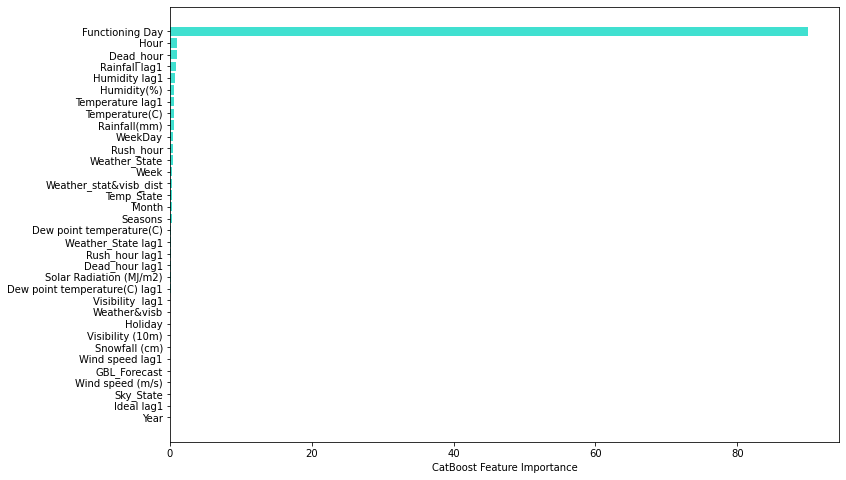

In [65]:
figure(figsize=(12,8))
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

---

### Submission Preparation

In [226]:
full_test_path = r"SeoulBikeDataTestFull.csv"

In [227]:
full_test = pd.read_csv(full_test_path)

In [228]:
test = df_test.copy()

In [229]:
test['Year'] = df_test['Date'].dt.year.astype('int')
test['Week'] = df_test['Date'].dt.isocalendar().week.astype('int')
test['Month'] = df_test['Date'].dt.month.astype('int') 
test['WeekDay'] = df_test['Date'].dt.weekday.astype('int')

In [230]:
#test.y.value_counts()

In [231]:
test.columns

Index(['ID', 'Date', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Week', 'Month', 'WeekDay'],
      dtype='object')

## Test Data Procc

In [232]:
map_data_series(test,'Functioning Day',['Yes','No'],[1,0])

In [233]:
map_data_series(test,'Holiday',['Holiday','No Holiday'],[1,0])

In [234]:
map_data_series(test,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [235]:
new_feature_data_series(test,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')
new_feature_data_series(test,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')

In [236]:
new_feature_data_series(test,['Hour'],day_night,'day_night')
new_feature_data_series(test,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')
new_feature_data_series(test,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [237]:
new_feature_data_series(test,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [238]:
test['Ideal'] = df_test[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [239]:
#new_feature_data_series(test,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
new_feature_data_series(test,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [240]:
new_feature_data_series(test,['Visibility (10m)'],visibility,'Visibility_cat')

In [241]:
new_feature_data_series(test,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [242]:
new_feature_data_series(test,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [243]:
test['Weather_State'] =test[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [244]:
map_data_series(test,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [245]:
test["Date_tmp"] = test['Date'].dt.to_period('M')
test = pd.merge(test, new_feature_df, on="Date_tmp", how="left")

In [246]:
new_feature_data_series(test,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [247]:
new_feature_data_series(test,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [248]:
new_feature_data_series(test,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [249]:
test['Sky_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 else 5, axis = 1)

In [250]:
test['Temp_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [251]:
new_feature_data_series(test,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [252]:
test["Temperature lag1"] = test["Temperature(C)"].shift(+t)
test["Temperature lag1"].fillna(0, inplace=True)

test["Rainfall lag1"] = test["Rainfall(mm)"].shift(+t)
test["Rainfall lag1"].fillna(0, inplace=True)

test["Visibility  lag1"] = test["Visibility (10m)"].shift(+t)
test["Visibility  lag1"].fillna(0, inplace=True)

test["Wind speed lag1"] = test["Wind speed (m/s)"].shift(+t)
test["Wind speed lag1"].fillna(0, inplace=True)

test["Weather_State lag1"] = test["Weather_State"].shift(+t)
test["Weather_State lag1"].fillna(0, inplace=True)

test["Humidity lag1"] = test["Humidity(%)"].shift(+t)
test["Humidity lag1"].fillna(0, inplace=True)

test["Rush_hour lag1"] = test["Rush_hour"].shift(+t)
test["Rush_hour lag1"].fillna(0, inplace=True)

test["Dead_hour lag1"] = test["Dead_hour"].shift(+t)
test["Dead_hour lag1"].fillna(0, inplace=True)

test["Ideal lag1"] = test["Ideal"].shift(+t)
test["Ideal lag1"].fillna(0, inplace=True)

test["Dew point temperature(C) lag1"] = test["Dew point temperature(C)"].shift(+t)
test["Dew point temperature(C) lag1"].fillna(0, inplace=True)

In [253]:
#test.drop(["Date", "y", "Date_tmp", "Dataset"], axis=1, inplace=True)
Xtest = test[selected_features]
Xtest.columns

Index(['Hour', 'Week', 'Month', 'Year', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Dew point temperature(C)', 'Snowfall (cm)',
       'Wind speed (m/s)', 'Visibility (10m)', 'WeekDay', 'Seasons', 'Holiday',
       'Temperature(C)', 'Humidity(%)', 'Functioning Day', 'Rush_hour',
       'Dead_hour', 'Weather_State', 'Weather&visb', 'Weather_stat&visb_dist',
       'Sky_State', 'Temp_State', 'GBL_Forecast', 'Temperature lag1',
       'Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
       'Weather_State lag1', 'Humidity lag1', 'Rush_hour lag1',
       'Dead_hour lag1', 'Ideal lag1', 'Dew point temperature(C) lag1'],
      dtype='object')

### model Predictions 

## XGB

In [254]:
preds_expXGB = 0
def XGB_Full_predict():
    global preds_expXGB
    Xtest = test[selected_features]

    predsXGB = XGB.predict(Xtest)
    preds_expXGB = np.round(np.exp(predsXGB))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expXGB, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expXGB) * 100,' %')
XGB_Full_predict()

(Full Test) XGB RMSLE: 0.3276139977638241
(Full Test) XGB R2 Score: 92.9669424477029  %


## GBR

In [255]:
preds_expGBR = 0
def GBR_Full_predict():
    global preds_expGBR
    Gtest = test[selected_features]

    predsGBR = GBR.predict(Gtest)
    preds_expGBR = np.round(np.exp(predsGBR))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expGBR, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expGBR) * 100,' %')
GBR_Full_predict()

(Full Test) XGB RMSLE: 0.32911224536596967
(Full Test) XGB R2 Score: 92.62132238932756  %


### CatBoost

In [256]:
preds_expCat =0 
def Catboost_Full_predict():
    global preds_expCat
    Ctest = test[selected_features]

    predsCat = model.predict(Ctest)
    preds_expCat = np.round(np.exp(predsCat))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expCat, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expCat) * 100,' %')
Catboost_Full_predict()   

(Full Test) XGB RMSLE: 0.32245327829360687
(Full Test) XGB R2 Score: 92.92355924000611  %


## Stacking 2

In [257]:
def percy(v1,v2,precision=50):
    lowest_score = 1
    lowest_percentage = 0
    for i in np.linspace(0,1,precision):
        percentage_1 = i
        percentage_2 = 1-percentage_1
        score = rmsle(full_test.y, v1*percentage_1 + v2 *percentage_2, False)
        if  score < lowest_score:
            lowest_score = score
            lowest_percentage = i
    print(f'lowest score {lowest_score} , best_percentage v1 : {lowest_percentage},v2 : {1-lowest_percentage}')
    print("(Full Test) 2stack:", r2_score(full_test.y, v1*percentage_1 + v2 *percentage_2 ) * 100,' %')
    return lowest_percentage , 1-lowest_percentage

In [258]:
def percy_3valves(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy(v1,v2,precision)
    pv1_3,pv3_1 = percy(v1,v3,precision)
    pv2_3,pv3_2 = percy(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('--------------------------------------------------------------------------------')
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [259]:
def percy_R2(v1,v2,precision=50):
    highest_score = 0
    highest_percentage = 0
    for i in np.linspace(0,1,precision):
        p1 = i
        p2 = 1-p1
        score = r2_score(full_test.y, v1*p1 + v2 *p2 )
        if  score > highest_score:
            highest_score = score
            highest_percentage = i
    print(f'highest_score {highest_score} , best_percentage v1 : {highest_percentage},v2 : {1-highest_percentage}')
    return highest_percentage , 1-highest_percentage

In [260]:
def percy_3valves_R2(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy_R2(v1,v2,precision)
    pv1_3,pv3_1 = percy_R2(v1,v3,precision)
    pv2_3,pv3_2 = percy_R2(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [261]:
percy_3valves_R2(preds_expGBR,preds_expCat,preds_expXGB,precision=50)

highest_score 0.9307069153217056 , best_percentage v1 : 0.36734693877551017,v2 : 0.6326530612244898
highest_score 0.9310101818367732 , best_percentage v1 : 0.3469387755102041,v2 : 0.653061224489796
highest_score 0.9330660062585469 , best_percentage v1 : 0.4897959183673469,v2 : 0.5102040816326531
(Full Test) rmsle 3_stacks:  0.3183673965218693
(Full Test) 3stack: 93.2803947281458  %
best_percentage v1 : 0.23809523809523805,v2 : 0.3741496598639456,v3 :  0.38775510204081637


(0.23809523809523805, 0.3741496598639456, 0.38775510204081637)

In [272]:
p1,p2,p3=percy_3valves(preds_expGBR,preds_expCat,preds_expXGB,precision=5)

lowest score 0.3196520289889389 , best_percentage v1 : 0.25,v2 : 0.75
(Full Test) 2stack: 92.62132238932756  %
lowest score 0.32426792406608296 , best_percentage v1 : 0.5,v2 : 0.5
(Full Test) 2stack: 92.62132238932756  %
lowest score 0.3181264326346453 , best_percentage v1 : 0.5,v2 : 0.5
(Full Test) 2stack: 92.92355924000611  %
--------------------------------------------------------------------------------
(Full Test) rmsle 3_stacks:  0.3181152608074982
(Full Test) 3stack: 93.27217461426946  %
best_percentage v1 : 0.25,v2 : 0.4166666666666667,v3 :  0.3333333333333333


### Save Submission

In [268]:
save_to_path = r'submissionjabalov.csv'

In [269]:
p1,p2,p3

(0.2653061224489796, 0.4217687074829932, 0.3129251700680273)

In [270]:
test['y'] =  preds_expGBR*p1 + preds_expCat*p2 + preds_expXGB*p3
test[["ID", "y"]].to_csv(save_to_path, index=False)

In [271]:
test.y

0        118.278911
1        105.054420
2         79.462584
3         55.557823
4         32.061224
           ...     
2995    1000.734698
2996     794.809517
2997     733.578217
2998     691.952377
2999     323.149653
Name: y, Length: 3000, dtype: float64